In [1]:
import pandas as pd
import numpy as np

import rfr_lasso
import rfr

import matplotlib.pyplot as plt

## Data  loading and analysis
There are separate files for each of the targets being predicted. There are 8 targets total, so there are 8 separate data sets.

- These data sets contain the descriptors and targets for the training data. There are ~1300 points in the formation energy sets (a, b) and ~750 points in the transition level sets (p32-m23). 
- The descriptors in each set are different, and were selected through expanding an original set of features and then using LASSO to select those most highly correlated with outputs.

**Formation Energies**

In [2]:
lasso_a = pd.read_csv('./xiaofeng_lasso/Lasso_HA_6.16.csv')

In [3]:
lasso_b = pd.read_csv('./xiaofeng_lasso/Lasso_HB_6.16.csv')

The formation energy training sets by semiconductor type are:
- ~80 % II-VI semicondcutors
- ~11 % IV-IV semicondcutors
- ~9 % III-V semiconductors

The formation energy training sets by semiconductor site are:
- ~60 % interstitial defect sites
- ~40 % substitutional defect sites

In [4]:
rfr.counter(lasso_a, 'Type')

Total entries:  1269


,Type,percent
II-VI,1014,79.91
IV-IV,145,11.43
III-V,110,8.67


In [5]:
rfr.counter(lasso_a, 'Site')

Total entries:  1269


,Site,percent
M_i_neut,267,21.04
M_i_A,264,20.80
M_A,257,20.25
M_i_B,253,19.94
M_B,228,17.97


------

**Transition Energy Levels**

In [51]:
lasso_p32 = pd.read_csv('./xiaofeng_lasso/Lasso_(+3,+2)_6.16.csv')

In [52]:
lasso_p21 = pd.read_csv('./xiaofeng_lasso/Lasso_(+2,+1)_6.16.csv')

In [53]:
lasso_0p1 = pd.read_csv('./xiaofeng_lasso/Lasso_(+1,0)_6.16.csv')

In [54]:
lasso_0m1 = pd.read_csv('./xiaofeng_lasso/Lasso_(0,-1)_6.16.csv')

In [55]:
lasso_m12 = pd.read_csv('./xiaofeng_lasso/Lasso_(-1,-2)_6.16.csv')

In [56]:
lasso_m23 = pd.read_csv('./xiaofeng_lasso/Lasso_(-2,-3)_6.16.csv')

The formation energy sets are:
- ~63 % II-VI semicondcutors
- ~21 % IV-IV semicondcutors
- ~16 % III-V semiconductors

The formation energy training sets by semiconductor site are:
- ~60 % interstitial defect sites
- ~40 % substitutional defect sites

In [12]:
rfr.counter(lasso_p32, 'Type')

Total entries:  748


,Type,percent
II-VI,471,62.97
IV-IV,160,21.39
III-V,117,15.64


In [13]:
rfr.counter(lasso_p32, 'Site')

Total entries:  748


,Site,percent
M_A,161,21.52
M_i_A,159,21.26
M_i_neut,154,20.59
M_i_B,143,19.12
M_B,131,17.51


-----

### Best random forest regression model parameters for each output 
**(determined through Bayesian optimization)**
- **∆H (A-rich)	:** num_trees=300, max_depth=10, max_feat='auto', min_samp_leaf=11, min_samples_split=6
- **∆H (B-rich)	:** num_trees=1000, max_depth=8, max_feat='auto', min_samp_leaf=13, min_samples_split=8
- **(+3/+2) :** num_trees=500, max_depth=9, max_feat='auto', min_samp_leaf=9, min_samples_split=20
- **(+2/+1) :** num_trees=300, max_depth=8, max_feat='sqrt', min_samp_leaf=8, min_samples_split=4
- **(+1/0) :** num_trees=450, max_depth=10, max_feat='auto', min_samp_leaf=8, min_samples_split=14
- **(0/-1) :** num_trees=300, max_depth=7, max_feat='log2', min_samp_leaf=3, min_samples_split=14
- **(-1/-2) :** num_trees=100, max_depth=9, max_feat='sqrt', min_samp_leaf=5, min_samples_split=3
- **(-2/-3) :** num_trees=250, max_depth=7, max_feat='sqrt', min_samp_leaf=5, min_samples_split=13

--------
------
## RFR model and parity plots
#### RFR model
I am runnning random forest regression models with  with cross validation using the function ``rfr_lasso_rmse``. The function takes in a data set (lasso_a, lasso_p32, etc) and performs RFR n-folds times, using a different train and test set in each fold. A train set and test set root mean squared error (RMSE) (a metric for how well a ML model is predicting) is calculated for each fold of the cross validation. The function returns a table where each row is the training and testing set RMSE values for each fold of the cross validation. The last row of the table is the mean and standard deviation across all the folds. By changing the arguement "output_type" to "type" or "site", the function can output values for how the model predicted specific types of compounds, ie a II-VI, or compounds with an interstitial defect. In these cases the function will output 4 (type) or 3 (defect site) tables. The first is the overall RMSE table, and the subsequent tables are for type: II-VI, III-V, IV-IV and for site: substitutional, interstitial defect site.

#### Parity plots
The parity plots are a visual check of how the model is predicting. The axes are the true output values vs the predicted output values, and each point represents an impurity doped semiconductor compound. If the model is predicting perfectly the points would fall on a line of slope 1. The function used to plot these is ``rfr_lasso_plot``. This function is similar to the function above, but it repeats the cross validation n-folds times so that the test value points can be calculated multiple times (in cross validation, every point in the input data set is only used as a test point once). So, cross validation is used to obtain uncertainty values so the points can be plotted with error bars. For more information on how cross validation measures uncertainty checkout RFR_uncertainty_crossvalidation.ipynb. Like the other function, by changing the arguement 'output_type' to 'type' or 'site', the parity plot can visually show where a type of point falls on the plot. The other outputs of the plotting functions are tables of the true value (dft value), mean and standard deviation of the predicted values over the folds * folds of cross validation.

## Formation Energies

### ∆H (A-rich)	

#### RMSE table

In [14]:
dHA_rmse, dHA_rmse_26, dHA_rmse_35, dHA_rmse_44 = \
    rfr_lasso.rfr_lasso_rmse(lasso_a, d_start=5, max_depth=10, max_feat='auto', 
                            min_samp_leaf=11, min_samples_split=6, num_trees=300,
                            output_type='type', folds=10)

In [15]:
_, dHA_rmse_sub, dHA_rmse_int = \
    rfr_lasso.rfr_lasso_rmse(lasso_a, d_start=5, max_depth=10, max_feat='auto', 
                            min_samp_leaf=11, min_samples_split=6, num_trees=300,
                            output_type='site', folds=10)

This is OVERALL how the model predicts for the ∆H (A-rich), formation energy of the dopant in A-rich chemical potential, target. The RMSE values are in eV, and can be read as the amount of uncertainty of all the predictions for this target. The closer this value is to 0, the better the model is predicting. The test RMSE is describes how the model predicts on "never before seen data", while the train RMSE is used to ensure the model is not overfitting and giving falsely confident predictions.

In [16]:
dHA_rmse

,train rmse,test rmse
0,0.725633,0.76881
1,0.719398,0.893465
2,0.711152,1.06234
3,0.716925,0.908193
4,0.711516,0.910666
5,0.724777,0.787834
6,0.720155,0.99218
7,0.719539,0.773897
8,0.698813,1.1746
9,0.70154,1.16726


The dataset used to train the model was made up of overwhelmingly II-VI semiconductor data, so it's interesting to look at how the model predicts each type of semiconductor separately. From the results, it's clear that the model predicts II-VI semiconductors with much higher accuracy than the III-V or IV-IV semiconductor types.

In [17]:
rfr.type_site_df('type', [dHA_rmse_26, dHA_rmse_35, dHA_rmse_44], 10)

,output,train rmse,test rmse
0,II-VI,0.5 +/- 0.006,0.67 +/- 0.077
1,III-V,1.19 +/- 0.042,1.57 +/- 0.433
2,IV-IV,1.28 +/- 0.033,1.61 +/- 0.49


The dataset used to train the model has more compounds with interstitial defect sites versus substitutional. From the results, it's clear that the model predicts compounds with defects at interstitial sites more accurately than substitutional sites.

In [18]:
rfr.type_site_df('site', [dHA_rmse_sub, dHA_rmse_int], 10)

,output,train rmse,test rmse
0,sub,0.76 +/- 0.019,1.03 +/- 0.228
1,int,0.68 +/- 0.014,0.87 +/- 0.203


#### Parity Plots
For the plots I have added a timer (thanks to tqdm) that updates a progress bar for every time the cv is repeated.

The parity plot for ∆H (A-rich)	clearly shows that at higher values, the model does a worse job predicting. The data seems to lean off the parity line as the predicted formation energies get higher in value. Evaluating the training dataset I found that <100 points had formation energy values above ~6.5 eV, maybe explaining the bad predictions.

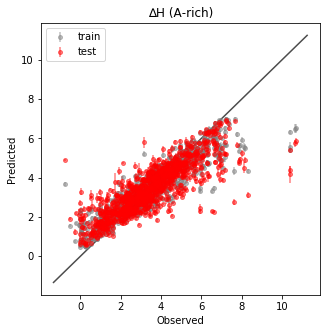

In [23]:
dHA_train_pred, dHA_test_pred, _ = \
    rfr_lasso.rfr_lasso_plot(lasso_a, d_start=5, max_depth=10, max_feat='auto', 
                            min_samp_leaf=11, min_samples_split=6, num_trees=300,
                            output_type='none', folds=10)

Mirroring the information from the RMSE tables, the II-VI values are predicted the most accurately (they stay closest to the parity line). The III-V and IV-IV points stray sometimes far from the line.

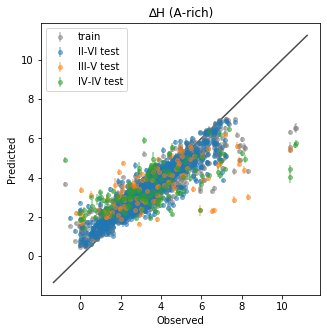

In [19]:
_, _, _, _, _ = \
    rfr_lasso.rfr_lasso_plot(lasso_a, d_start=5, max_depth=10, max_feat='auto', 
                            min_samp_leaf=11, min_samples_split=6, num_trees=300,
                            output_type='type', folds=10)

Interestingly, the parity plot doesn't obviously show that the interstitial sites are predicted much better than the substitutional defect sites. Both seem to have points that stray far from parity line.

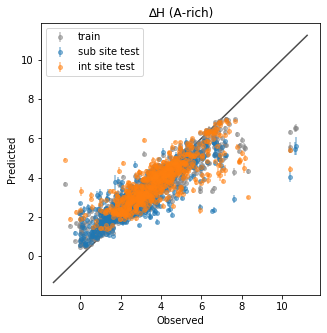

In [20]:
_, _, _, _ = \
    rfr_lasso.rfr_lasso_plot(lasso_a, d_start=5, max_depth=10, max_feat='auto', 
                            min_samp_leaf=11, min_samples_split=6, num_trees=300,
                            output_type='site', folds=10)

This plots the deviation in prediction from the real value (prediction error), vs the standard deviation from the folds of CV. Ideally, these two would have a positive and linear relationship, where a greater standard deviation would indicate a very incorrect prediction. Though there seems to be some positive correlation, it appears that most of the test points that have a large error do not have a large standard deviation and most are clustered toward the bottom left of the plot

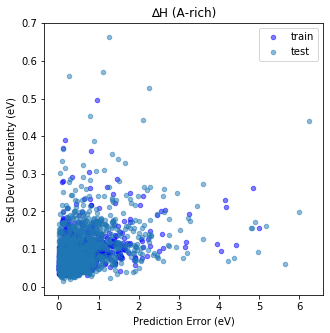

In [44]:
pred_stddev_plot(dHA_train_pred, dHA_test_pred, '∆H (A-rich)')

### ∆H (B-rich)	

In [28]:
dHB_rmse, dHB_rmse_26, dHB_rmse_35, dHB_rmse_44 = \
    rfr_lasso.rfr_lasso_rmse(lasso_b, d_start=5, num_trees=1000, max_depth=8,
                             max_feat='auto', min_samp_leaf=13, min_samples_split=8,
                            output_type='type', folds=10)

In [29]:
_, dHB_rmse_sub, dHB_rmse_int = \
    rfr_lasso.rfr_lasso_rmse(lasso_b, d_start=5, num_trees=1000, max_depth=8,
                             max_feat='auto', min_samp_leaf=13, min_samples_split=8,
                            output_type='site', folds=10)

This is overall prediction for the ∆H (B-rich), formation energy of the dopant in B-rich chemical potential, target. The range of possible for this target is larger than ∆H (A-rich), which could be why the RMSE is slightly higher.

In [30]:
dHB_rmse

,train rmse,test rmse
0,0.884722,0.894902
1,0.880418,1.1359
2,0.872396,1.20048
3,0.87422,0.986661
4,0.861605,1.04795
5,0.865083,1.15581
6,0.879847,1.1423
7,0.86773,1.00512
8,0.846809,1.24127
9,0.871069,1.33022


As in the formation energy for A-rich sites, it's clear that the model predicts II-VI semiconductors with much higher accuracy than the III-V or IV-IV semiconductor types.

In [31]:
rfr.type_site_df('type', [dHB_rmse_26, dHB_rmse_35, dHB_rmse_44], 10)

,output,train rmse,test rmse
0,II-VI,0.7 +/- 0.006,0.9 +/- 0.083
1,III-V,1.36 +/- 0.059,1.7 +/- 0.579
2,IV-IV,1.34 +/- 0.042,1.63 +/- 0.539


As in the formation energy for A-rich sites, it's clear that the model predicts compounds with defects at interstitial sites more accurately than substitutional sites.

In [32]:
rfr.type_site_df('site', [dHB_rmse_sub, dHB_rmse_int], 10)

,output,train rmse,test rmse
0,sub,0.95 +/- 0.021,1.23 +/- 0.193
1,int,0.82 +/- 0.019,1.02 +/- 0.196


### Parity Plots
The parity plots for the B-rich site show very similar results to the A-rich sites with higher values not being predicted as well.

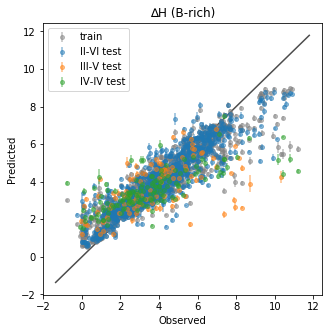

In [102]:
_, _, _, _, _ = \
    rfr_lasso.rfr_lasso_plot(lasso_b, d_start=5, num_trees=1000, max_depth=8,
                             max_feat='auto', min_samp_leaf=13, min_samples_split=8,
                            output_type='type', folds=10)

Interestingly, the parity plot doesn't obviously show that the interstitial sites are predicted much better than the substitutional defect sites. Both seem to have points that stray far from parity line.

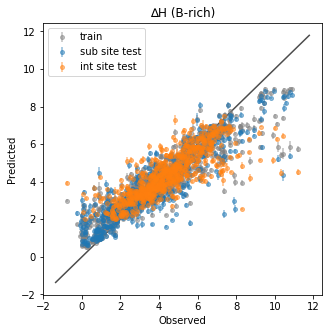

In [103]:
_, _, _, _ = \
    rfr_lasso.rfr_lasso_plot(lasso_b, d_start=5, num_trees=1000, max_depth=8,
                             max_feat='auto', min_samp_leaf=13, min_samples_split=8,
                            output_type='site', folds=10)

----
----
## Transition Levels

### (+3/+2)

#### RMSE table

In [45]:
p32_rmse, p32_rmse_26, p32_rmse_35, p32_rmse_44 = \
    rfr_lasso.rfr_lasso_rmse(lasso_p32, d_start=5, num_trees=500, max_depth=9, max_feat='auto',
                             min_samp_leaf=9, min_samples_split=20,
                            output_type='type', folds=10)

In [46]:
_, p32_rmse_sub, p32_rmse_int = \
    rfr_lasso.rfr_lasso_rmse(lasso_p32, d_start=5, num_trees=500, max_depth=9, max_feat='auto',
                             min_samp_leaf=9, min_samples_split=20,
                            output_type='site', folds=10)

The range of values for the transition values is much smaller than the formation energies, and the error in the predictions reflect that. 

In [47]:
p32_rmse

,train rmse,test rmse
0,0.232482,0.28534
1,0.232379,0.321692
2,0.227823,0.387662
3,0.232042,0.288374
4,0.228237,0.34939
5,0.235273,0.239183
6,0.234582,0.322937
7,0.233797,0.276907
8,0.227989,0.364974
9,0.236561,0.27218


In the formation energy dataset, II-VI semiconductors make up a smaller (but still significant) portion of the data. Though, unlike the formation energies, the predicition across types of semiconductors are very similar to one another.

In [49]:
rfr.type_site_df('type', [p32_rmse_26, p32_rmse_35, p32_rmse_44], 10)

,output,train rmse,test rmse
0,II-VI,0.24 +/- 0.004,0.32 +/- 0.056
1,III-V,0.23 +/- 0.005,0.31 +/- 0.097
2,IV-IV,0.21 +/- 0.005,0.28 +/- 0.058


Predictions by type of defect site are also very similar for the (+3/+2) transition level

In [50]:
rfr.type_site_df('site', [p32_rmse_sub, p32_rmse_int], 10)

,output,train rmse,test rmse
0,sub,0.23 +/- 0.003,0.32 +/- 0.074
1,int,0.23 +/- 0.003,0.3 +/- 0.053


#### Parity Plot
The interstitial sites predict better than the substitutional sites. This isn't very clear from the parity plot where the two seem to stay on the parity line for lower energy predictions and they start to deviate for higher energy predictions. As can be seen from the poitns, most of the values lie below -0.5 eV (where the strongest predictions are).

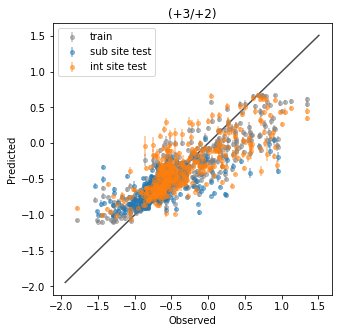

In [58]:
_, _, _, _ = \
    rfr_lasso.rfr_lasso_plot(lasso_p32, d_start=5, num_trees=500, max_depth=9, max_feat='auto',
                             min_samp_leaf=9, min_samples_split=20,
                            output_type='site', folds=10)

### (+2/+1)

#### RMSE table

In [59]:
p21_rmse, p21_rmse_26, p21_rmse_35, p21_rmse_44 = \
    rfr_lasso.rfr_lasso_rmse(lasso_p21, d_start=5, num_trees=300, max_depth=8,
                             max_feat='sqrt', min_samp_leaf=8, min_samples_split=4,
                             output_type='type', folds=10)

In [60]:
_, p21_rmse_sub, p21_rmse_int = \
    rfr_lasso.rfr_lasso_rmse(lasso_p21, d_start=5, num_trees=300, max_depth=8,
                             max_feat='sqrt', min_samp_leaf=8, min_samples_split=4,
                             output_type='site', folds=10)

The range of values for the transition values is much smaller than the formation energies, and the error in the predictions reflect that. 

In [61]:
p21_rmse.loc[10]

train rmse    0.28 +/- 0.003
test rmse     0.35 +/- 0.044
Name: 10, dtype: object

As in the previous transition level, the predicition across types of semiconductors are very similar to one another.

In [62]:
rfr.type_site_df('type', [p21_rmse_26, p21_rmse_35, p21_rmse_44], 10)

,output,train rmse,test rmse
0,II-VI,0.28 +/- 0.003,0.35 +/- 0.05
1,III-V,0.27 +/- 0.008,0.35 +/- 0.093
2,IV-IV,0.27 +/- 0.008,0.34 +/- 0.07


Predictions by type of defect site are also very similar for the (+3/+2) transition level

In [63]:
rfr.type_site_df('site', [p21_rmse_sub, p21_rmse_int], 10)

,output,train rmse,test rmse
0,sub,0.32 +/- 0.008,0.41 +/- 0.082
1,int,0.24 +/- 0.002,0.3 +/- 0.039


#### Parity Plots

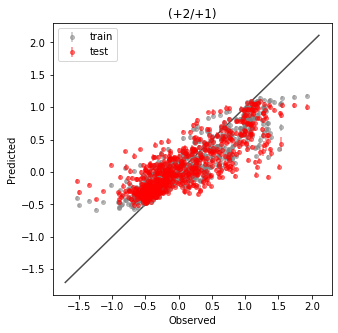

In [67]:
p21_train_pred, p21_test_pred, _ = \
    rfr_lasso.rfr_lasso_plot(lasso_p21, d_start=5, num_trees=300, max_depth=8,
                             max_feat='sqrt', min_samp_leaf=8, min_samples_split=4,
                             output_type='none', folds=10)

In this plot vs the dHA plot, the deviation in predictions seem to have a stronger correlation with the predictions with higher standard deviation

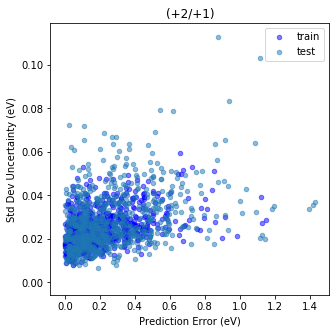

In [69]:
pred_stddev_plot(p21_train_pred, p21_test_pred, '(+2/+1)')

### (+1/0)

#### RMSE table

In [70]:
p01_rmse, p01_rmse_26, p01_rmse_35, p01_rmse_44 = \
    rfr_lasso.rfr_lasso_rmse(lasso_0p1, d_start=5, num_trees=450, max_depth=10,
                             max_feat='auto', min_samp_leaf=8, min_samples_split=14,
                             output_type='type', folds=10)

In [71]:
_, p01_rmse_sub, p01_rmse_int = \
    rfr_lasso.rfr_lasso_rmse(lasso_0p1, d_start=5, num_trees=450, max_depth=10,
                             max_feat='auto', min_samp_leaf=8, min_samples_split=14,
                             output_type='site', folds=10)

The range of values for the transition values is much smaller than the formation energies, and the error in the predictions reflect that. 

In [73]:
p01_rmse.loc[10]

train rmse    0.27 +/- 0.004
test rmse     0.36 +/- 0.043
Name: 10, dtype: object

The predicition across types of semiconductors are fairly similar to one another, though the III-V semiconductor seems to predict worse than the other types.

In [74]:
rfr.type_site_df('type', [p01_rmse_26, p01_rmse_35, p01_rmse_44], 10)

,output,train rmse,test rmse
0,II-VI,0.26 +/- 0.005,0.35 +/- 0.048
1,III-V,0.29 +/- 0.006,0.42 +/- 0.073
2,IV-IV,0.25 +/- 0.008,0.34 +/- 0.075


Predictions by type of defect site are skewed toward interstitial defect sights (again, the training data set is ~60% interstitial, 40% substitutional)

In [75]:
rfr.type_site_df('site', [p01_rmse_sub, p01_rmse_int], 10)

,output,train rmse,test rmse
0,sub,0.33 +/- 0.005,0.45 +/- 0.056
1,int,0.21 +/- 0.005,0.29 +/- 0.036


#### Parity Plots

From the RMSE table we would expect the III-V semiconductors to predic the worst. Though it seems that there are some of parity orange points, it's hard to tell the difference between the sc types.

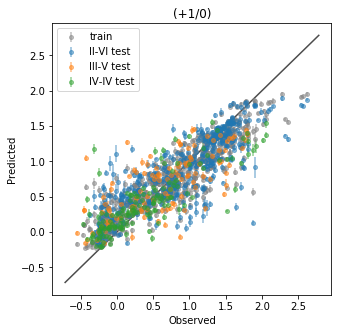

In [72]:
_, _, _, _, _ = \
    rfr_lasso.rfr_lasso_plot(lasso_0p1, d_start=5, num_trees=450, max_depth=10,
                             max_feat='auto', min_samp_leaf=8, min_samples_split=14,
                             output_type='type', folds=10)

### (0/-1)

#### RMSE table

In [76]:
m01_rmse, m01_rmse_26, m01_rmse_35, m01_rmse_44 = \
    rfr_lasso.rfr_lasso_rmse(lasso_0m1, d_start=5, num_trees=300, max_depth=7,
                             max_feat='log2', min_samp_leaf=3, min_samples_split=14,
                             output_type='type', folds=10)

In [77]:
_, m01_rmse_sub, m01_rmse_int = \
    rfr_lasso.rfr_lasso_rmse(lasso_0m1, d_start=5, num_trees=300, max_depth=7,
                             max_feat='log2', min_samp_leaf=3, min_samples_split=14,
                             output_type='site', folds=10)

The variation between folds is much smaller than the formation energies.

In [78]:
m01_rmse

,train rmse,test rmse
0,0.262332,0.320352
1,0.261485,0.360834
2,0.266048,0.320106
3,0.263124,0.349782
4,0.254583,0.457536
5,0.25986,0.369451
6,0.263645,0.304716
7,0.259748,0.36305
8,0.260833,0.351104
9,0.260314,0.348026


The predicition across types of semiconductors are fairly similar to one another, though the III-V semiconductor seems to predict worse than the other types.

In [79]:
rfr.type_site_df('type', [m01_rmse_26, m01_rmse_35, m01_rmse_44], 10)

,output,train rmse,test rmse
0,II-VI,0.26 +/- 0.005,0.34 +/- 0.065
1,III-V,0.3 +/- 0.006,0.42 +/- 0.058
2,IV-IV,0.24 +/- 0.007,0.33 +/- 0.074


Predictions by type of defect site are skewed toward interstitial defect sights (again, the training data set is ~60% interstitial, 40% substitutional)

In [80]:
rfr.type_site_df('site', [m01_rmse_sub, m01_rmse_int], 10)

,output,train rmse,test rmse
0,sub,0.34 +/- 0.004,0.47 +/- 0.064
1,int,0.19 +/- 0.003,0.26 +/- 0.031


#### Parity Plots

From the RMSE table we would expect the substitutional defect compounds to predict the worse than interstitial. At lower energies (between -0.5 and 0.5) the predictions for the substitutional sights all seem high. Besides that, most points stick fairly close to the parity line.

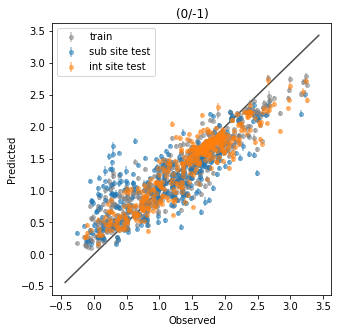

In [82]:
_, _, _, _ = \
    rfr_lasso.rfr_lasso_plot(lasso_0m1, d_start=5, num_trees=300, max_depth=7,
                             max_feat='log2', min_samp_leaf=3, min_samples_split=14,
                             output_type='site', folds=10)

### (-1/-2)

#### RMSE table

In [83]:
m12_rmse, m12_rmse_26, m12_rmse_35, m12_rmse_44 = \
    rfr_lasso.rfr_lasso_rmse(lasso_m12, d_start=5, num_trees=100, max_depth=9,
                             max_feat='sqrt', min_samp_leaf=5, min_samples_split=3,
                             output_type='type', folds=10)

In [89]:
_, m12_rmse_sub, m12_rmse_int = \
    rfr_lasso.rfr_lasso_rmse(lasso_m12, d_start=5, num_trees=100, max_depth=9,
                             max_feat='sqrt', min_samp_leaf=5, min_samples_split=3,
                             output_type='site', folds=10)

In [86]:
m12_rmse.iloc[10]

train rmse    0.22 +/- 0.003
test rmse     0.29 +/- 0.038
Name: 10, dtype: object

The predicition across types of semiconductors are fairly similar to one another, though the III-V semiconductor seems to predict worse than the other types (as in the previous 3 targets).

In [87]:
rfr.type_site_df('type', [m12_rmse_26, m12_rmse_35, m12_rmse_44], 10)

,output,train rmse,test rmse
0,II-VI,0.23 +/- 0.005,0.29 +/- 0.055
1,III-V,0.22 +/- 0.003,0.3 +/- 0.041
2,IV-IV,0.21 +/- 0.007,0.27 +/- 0.067


Predictions by type of defect site are skewed toward interstitial defect sights (again, the training data set is ~60% interstitial, 40% substitutional)

In [90]:
rfr.type_site_df('site', [m12_rmse_sub, m12_rmse_int], 10)

,output,train rmse,test rmse
0,sub,0.27 +/- 0.006,0.35 +/- 0.054
1,int,0.19 +/- 0.004,0.25 +/- 0.042


#### Parity Plots

As seen in the previous plot, the lower energy substitutional points (0-1.5 eV) are predicted to much higher than their actual values. The other points seem to stick close to the parity line.

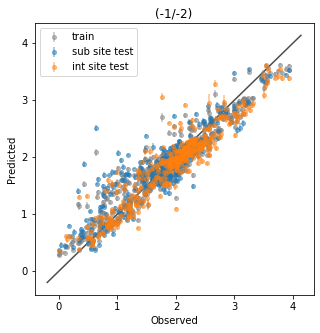

In [91]:
_, _, _, _ = \
    rfr_lasso.rfr_lasso_plot(lasso_m12, d_start=5, num_trees=100, max_depth=9,
                             max_feat='sqrt', min_samp_leaf=5, min_samples_split=3,
                             output_type='site', folds=10)

### (-2/-3)

#### RMSE table

In [93]:
m23_rmse, m23_rmse_26, m23_rmse_35, m23_rmse_44 = \
    rfr_lasso.rfr_lasso_rmse(lasso_m23, d_start=5, num_trees=250, max_depth=7,
                             max_feat='sqrt', min_samp_leaf=5, min_samples_split=13,
                             output_type='type', folds=10)

In [95]:
_, m23_rmse_sub, m23_rmse_int = \
    rfr_lasso.rfr_lasso_rmse(lasso_m23, d_start=5, num_trees=250, max_depth=7,
                             max_feat='sqrt', min_samp_leaf=5, min_samples_split=13,
                             output_type='site', folds=10)

The variation between folds is much smaller than the formation energies.

In [96]:
m23_rmse

,train rmse,test rmse
0,0.210524,0.232549
1,0.214373,0.199131
2,0.20721,0.284328
3,0.212158,0.223468
4,0.207388,0.270634
5,0.19761,0.331608
6,0.208928,0.286752
7,0.211548,0.226333
8,0.214289,0.221462
9,0.214653,0.194119


The predicition across types of semiconductors are fairly similar to one another, though the III-V semiconductor seems to predict worse than the other types.

In [97]:
rfr.type_site_df('type', [m23_rmse_26, m23_rmse_35, m23_rmse_44], 10)

,output,train rmse,test rmse
0,II-VI,0.23 +/- 0.007,0.25 +/- 0.067
1,III-V,0.17 +/- 0.006,0.22 +/- 0.054
2,IV-IV,0.18 +/- 0.005,0.23 +/- 0.036


Predictions by type of defect site are skewed toward interstitial defect sights (again, the training data set is ~60% interstitial, 40% substitutional)

In [98]:
rfr.type_site_df('site', [m23_rmse_sub, m23_rmse_int], 10)

,output,train rmse,test rmse
0,sub,0.22 +/- 0.004,0.26 +/- 0.038
1,int,0.21 +/- 0.007,0.23 +/- 0.065


#### Parity Plots

There is very little standard deviation between folds in the cross validation leading to almost invisible error bars. But, the predictions stick on the parity line over the the whole energy range of predicted values.

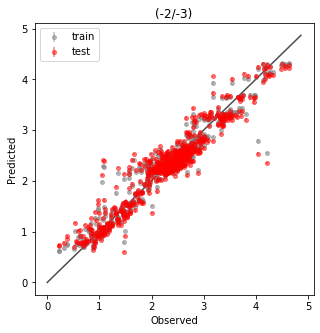

In [100]:
m23_train_pred, m23_test_pred, _ = \
    rfr_lasso.rfr_lasso_plot(lasso_m23, d_start=5, num_trees=250, max_depth=7,
                             max_feat='sqrt', min_samp_leaf=5, min_samples_split=13,
                             output_type='none', folds=10)

In this plot vs the dHA plot and the (+2/+1) plot, the deviation in predictions seem to have very little correlation with the standard deviation across folds of the predictions. Mostly lower prediction errors give high standard deviations.

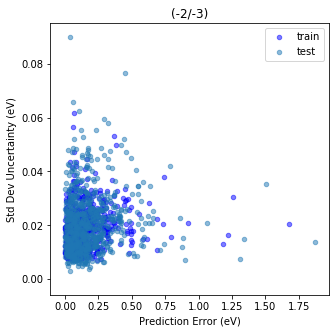

In [101]:
pred_stddev_plot(m23_train_pred, m23_test_pred, '(-2/-3)')

-----------
Prediction error vs standard deviation uncertainty plotting function

In [68]:
def pred_stddev_plot(df1, df2, plt_title):
    
   
    diff_train = np.abs(df1['dft_train'] - df1['mean_train'])
    std_train = df1['stddev_train']
    diff_test = np.abs(df2['dft_test'] - df2['mean_test'])
    std_test = df2['stddev_test']

    fig, ax = plt.subplots(figsize=(5,5))
    ax.scatter(diff_train, std_train, alpha = 0.5, label='train', color='blue', s = 20, zorder=2)
    ax.scatter(diff_test, std_test, alpha = 0.5, label='test', s = 20, zorder=3)

    ax.set_xlabel('Prediction Error (eV)')
    ax.set_ylabel('Std Dev Uncertainty (eV)')
    ax.set_title(plt_title)
    ax.legend()
    plt.show()